# What Is MLlib?
MLlib is a package, built on and included in Spark, that provides interfaces for gathering and
cleaning data, feature engineering and feature selection, training and tuning large-scale
supervised and unsupervised machine learning models, and using those models in production.
## When and why should you use MLlib (versus scikit-learn, TensorFlow, or foo package)
There are two key use cases where you want to leverage Spark’s ability to scale. First, you want
to leverage Spark for preprocessing and feature generation to reduce the amount of time it might
take to produce training and test sets from a large amount of data. Then you might leverage
single-machine learning libraries to train on those given data sets. Second, when your input data
or model size become too difficult or inconvenient to put on one machine, use Spark to do the
heavy lifting. Spark makes distributed machine learning very simple.

# High-Level MLlib Concepts
In MLlib there are several fundamental “structural” types: transformers, estimators, evaluators,
and pipelines. By structural, we mean you will think in terms of these types when you define an
end-to-end machine learning pipeline. They’ll provide the common language for defining what
belongs in what part of the pipeline. Figure 24-2 illustrates the overall workflow that you will
follow when developing machine learning models in Spark.
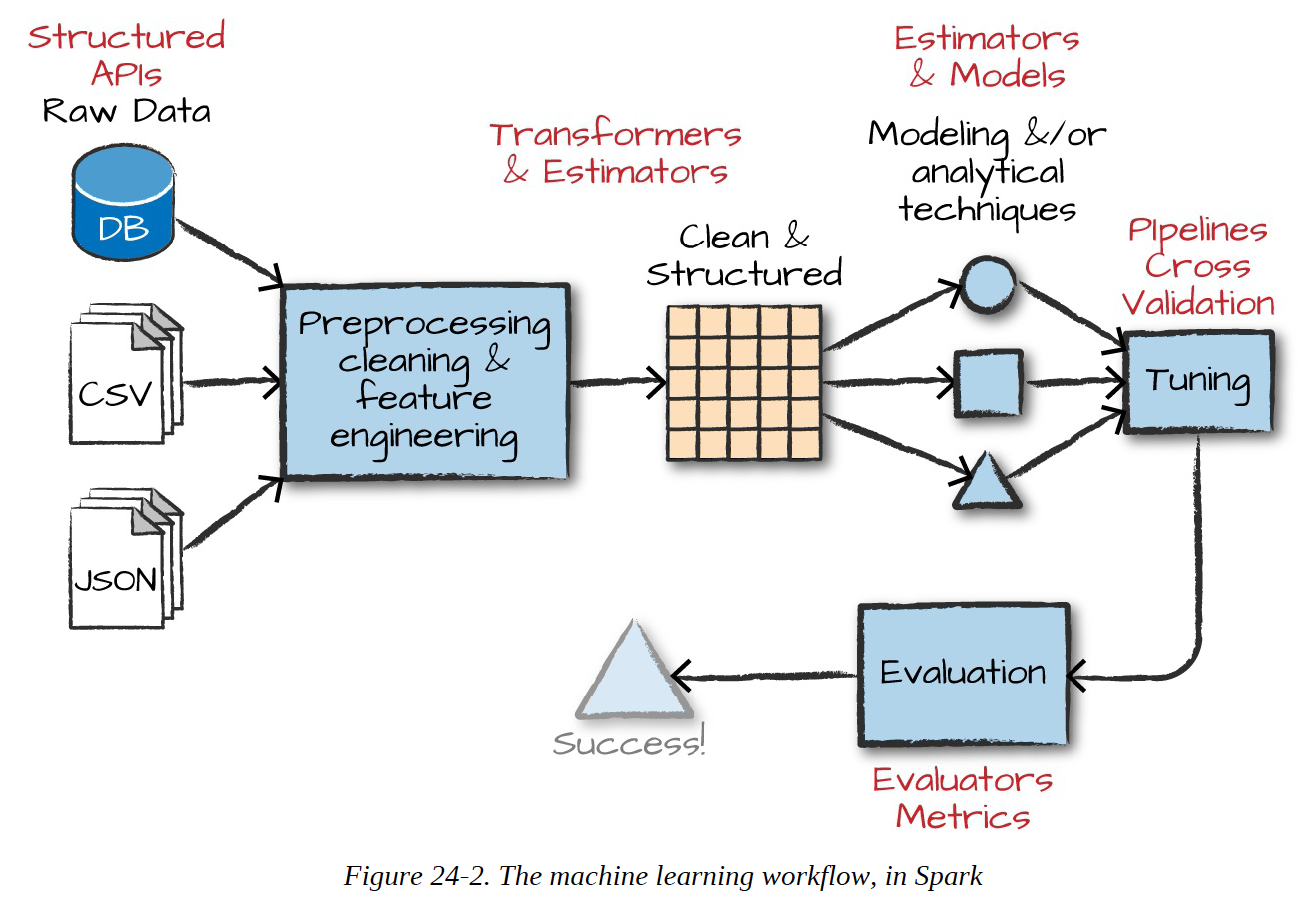

Transformers are functions that convert raw data in some way. This might be to create a new
interaction variable (from two other variables), normalize a column, or simply change an
Integer into a Double type to be input into a model. An example of a transformer is one that
converts string categorical variables into numerical values that can be used in MLlib.
Transformers are primarily used in preprocessing and feature engineering. Transformers take a
DataFrame as input and produce a new DataFrame as output, as illustrated in Figure 24-3.
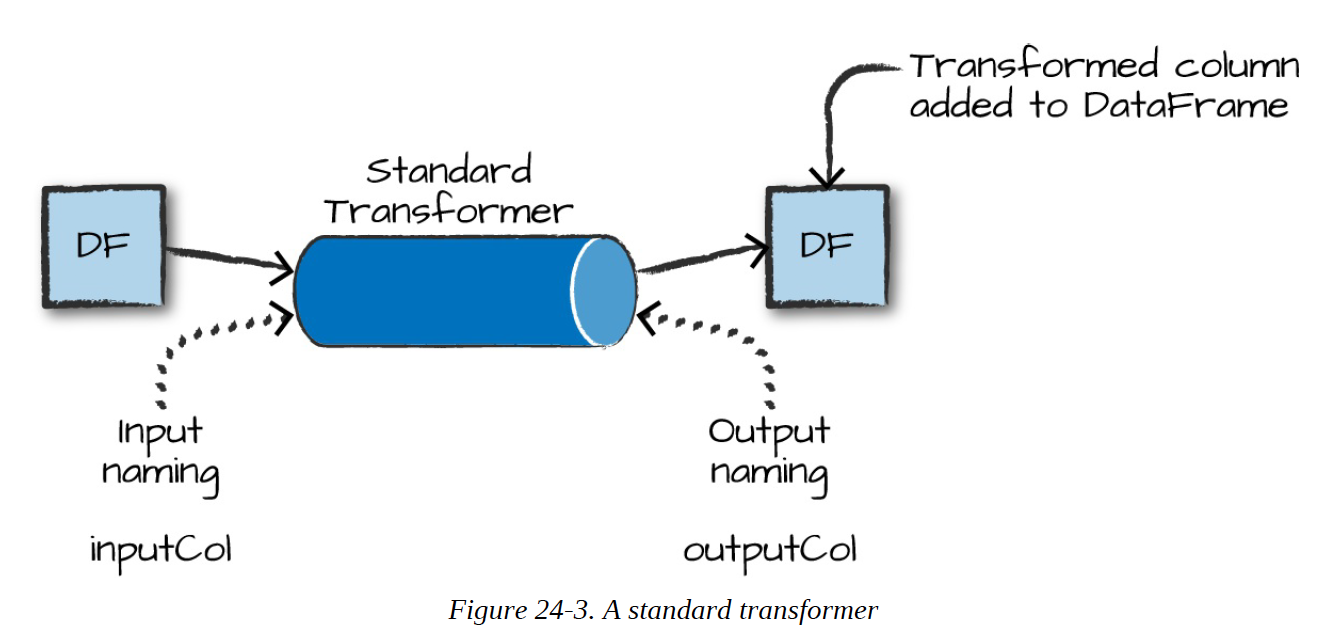

Estimators are one of two kinds of things. First, estimators can be a kind of transformer that is
initialized with data. For instance, to normalize numerical data we’ll need to initialize our
transformation with some information about the current values in the column we would like to
normalize. This requires two passes over our data—the initial pass generates the initialization
values and the second actually applies the generated function over the data. In the Spark’s
nomenclature, algorithms that allow users to train a model from data are also referred to as
estimators.

An evaluator allows us to see how a given model performs according to criteria we specify like a
receiver operating characteristic (ROC) curve. After we use an evaluator to select the best model
from the ones we tested, we can then use that model to make predictions.
From a high level we can specify each of the transformations, estimations, and evaluations one
by one, but it is often easier to specify our steps as stages in a pipeline. This pipeline is similar to
scikit-learn’s pipeline concept.

## Low-level data types
In addition to the structural types for building pipelines, there are also several lower-level data
types you may need to work with in MLlib (Vector being the most common). Whenever we pass
a set of features into a machine learning model, we must do it as a vector that consists of
Doubles. This vector can be either sparse (where most of the elements are zero) or dense (where
there are many unique values). Vectors are created in different ways. To create a dense vector,
we can specify an array of all the values. To create a sparse vector, we can specify the total size
and the indices and values of the non-zero elements. Sparse is the best format, as you might have
guessed, when the majority of values are zero as this is a more compressed representation. Here
is an example of how to manually create a Vector:

In [1]:
# in Python
from pyspark.ml.linalg import Vectors
denseVec = Vectors.dense(1.0, 2.0, 3.0)
size = 3
idx = [1, 2] # locations of non-zero elements in vector
values = [2.0, 3.0]
sparseVec = Vectors.sparse(size, idx, values)

## MLlib in Action
Now that we have described some of the core pieces you can expect to come across, let’s create a
simple pipeline to demonstrate each of the components. We’ll use a small synthetic dataset that
will help illustrate our point. Let’s read the data in and see a sample before talking about it
further:

In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [4]:
df = spark.read.json("../data/simple-ml")
df.orderBy("value2").show()

+-----+----+------+------------------+
|color| lab|value1|            value2|
+-----+----+------+------------------+
|green|good|     1|14.386294994851129|
|green| bad|    16|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|     8|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|green| bad|    16|14.386294994851129|
|green|good|    12|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red|good|    35|14.386294994851129|
|  red| bad|     2|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|  red| bad|    16|14.386294994851129|
| blue| bad|     8|14.386294994851129|
|green|good|     1|14.386294994851129|
|green|good|    12|14.386294994851129|
| blue| bad|     8|14.386294994851129|
|  red|good|    35|14.386294994851129|
| blue| bad|    12|14.386294994851129|
|  red| bad|    16|14.386294994851129|
|green|good|    12|14.386294994851129|
+-----+----+------+------------------+
only showing top 20 rows



## Feature Engineering with Transformers
When we use MLlib, all inputs to machine learning algorithms (with several exceptions
discussed in later chapters) in Spark must consist of type Double (for labels) and
Vector[Double] (for features). The current dataset does not meet that requirement and therefore
we need to transform it to the proper format.

To achieve this in our example, we are going to specify an RFormula. This is a declarative
language for specifying machine learning transformations and is simple to use once you
understand the syntax. RFormula supports a limited subset of the R operators that in practice
work quite well for simple models and manipulations (we demonstrate the manual approach to
this problem in Chapter 25)

In [5]:
from pyspark.ml.feature import RFormula
supervised = RFormula(formula="lab ~ . + color:value1 + color:value2")

At this point, we have declaratively specified how we would like to change our data into what we
will train our model on. The next step is to fit the RFormula transformer to the data to let it
discover the possible values of each column. Not all transformers have this requirement but
because RFormula will automatically handle categorical variables for us, it needs to determine
which columns are categorical and which are not, as well as what the distinct values of the
categorical columns are. For this reason, we have to call the fit method. Once we call fit, it
returns a “trained” version of our transformer we can then use to actually transform our data.

In [6]:
fittedRF = supervised.fit(df)
preparedDF = fittedRF.transform(df)
preparedDF.show()

+-----+----+------+------------------+--------------------+-----+
|color| lab|value1|            value2|            features|label|
+-----+----+------+------------------+--------------------+-----+
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| bad|     8|14.386294994851129|(10,[2,3,6,9],[8....|  0.0|
| blue| bad|    12|14.386294994851129|(10,[2,3,6,9],[12...|  0.0|
|green|good|    15| 38.97187133755819|(10,[1,2,3,5,8],[...|  1.0|
|green|good|    12|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
|green| bad|    16|14.386294994851129|(10,[1,2,3,5,8],[...|  0.0|
|  red|good|    35|14.386294994851129|(10,[0,2,3,4,7],[...|  1.0|
|  red| bad|     1| 38.97187133755819|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|     2|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red| bad|    16|14.386294994851129|(10,[0,2,3,4,7],[...|  0.0|
|  red|good|    45| 38.97187133755819|(10,[0,2,3,4,7],[...|  1.0|
|green|good|     1|14.386294994851129|(10,[1,2,3,5,8],[...|  1.0|
| blue| ba

In the output we can see the result of our transformation—a column called features that has our
previously raw data. What’s happening behind the scenes is actually pretty simple. RFormula
inspects our data during the fit call and outputs an object that will transform our data according
to the specified formula, which is called an RFormulaModel. This “trained” transformer always
has the word Model in the type signature. When we use this transformer, Spark automatically
converts our categorical variable to Doubles so that we can input it into a (yet to be specified)
machine learning model. In particular, it assigns a numerical value to each possible color
category, creates additional features for the interaction variables between colors and
value1/value2, and puts them all into a single vector. We then call transform on that object in
order to transform our input data into the expected output data.

Thus far you (pre)processed the data and added some features along the way. Now it is time to
actually train a model (or a set of models) on this dataset. In order to do this, you first need to
prepare a test set for evaluation.

Let’s create a simple test set based off a random split of the data now (we’ll be using this test set
throughout the remainder of the chapter):

In [7]:
train, test = preparedDF.randomSplit([0.7, 0.3])

## Estimators
Now that we have transformed our data into the correct format and created some valuable
features, it’s time to actually fit our model. In this case we will use a classification algorithm
called logistic regression. To create our classifier we instantiate an instance of
LogisticRegression, using the default configuration or hyperparameters. We then set the label
columns and the feature columns; the column names we are setting—label and features—are
actually the default labels for all estimators in Spark MLlib, and in later chapters we omit them:

In [8]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="label",featuresCol="features")

Before we actually go about training this model, let’s inspect the parameters. This is also a great
way to remind yourself of the options available for each particular model:

In [10]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

Upon instantiating an untrained algorithm, it becomes time to fit it to data. In this case, this
returns a LogisticRegressionModel:

In [11]:
fittedLR = lr.fit(train)

This code will kick off a Spark job to train the model. As opposed to the transformations that you
saw throughout the book, the fitting of a machine learning model is eager and performed
immediately.

Once complete, you can use the model to make predictions. Logically this means tranforming
features into labels. We make predictions with the transform method. For example, we can
transform our training dataset to see what labels our model assigned to the training data and how
those compare to the true outputs. This, again, is just another DataFrame we can manipulate.
Let’s perform that prediction with the following code snippet:

In [12]:
fittedLR.transform(train).select("label", "prediction").show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



## A REVIEW OF HYPERPARAMETERS
Although we mentioned them previously, let’s more formally define hyperparameters.
Hyperparameters are configuration parameters that affect the training process, such as model
architecture and regularization. They are set prior to starting training. For instance, logistic
regression has a hyperparameter that determines how much regularization should be
performed on our data through the training phase (regularization is a technique that pushes
models against overfitting data). You’ll see in the next couple of pages that we can set up our
pipeline to try different hyperparameter values (e.g., different regularization values) in order
to compare different variations of the same model against one another.

## Pipelining Our Workflow
As you probably noticed, if you are performing a lot of transformations, writing all the steps and
keeping track of DataFrames ends up being quite tedious. That’s why Spark includes the
Pipeline concept. A pipeline allows you to set up a dataflow of the relevant transformations
that ends with an estimator that is automatically tuned according to your specifications, resulting
in a tuned model ready for use. Figure 24-4 illustrates this process.
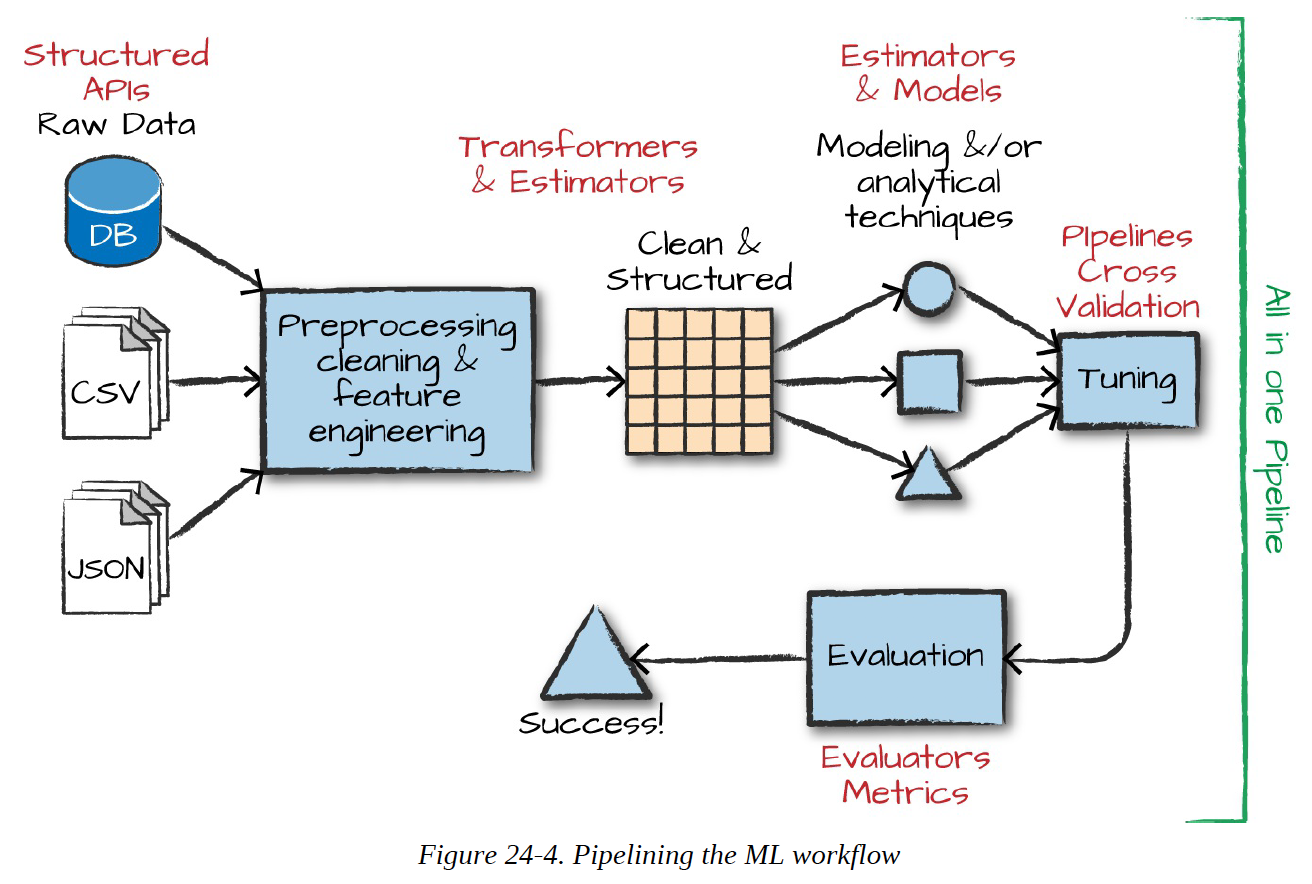

Note that it is essential that instances of transformers or models are not reused across different
pipelines. Always create a new instance of a model before creating another pipeline.

In order to make sure we don’t overfit, we are going to create a holdout test set and tune our
hyperparameters based on a validation set (note that we create this validation set based on the
original dataset, not the preparedDF used in the previous pages):

In [13]:
train, test = df.randomSplit([0.7, 0.3])

Now that you have a holdout set, let’s create the base stages in our pipeline. A stage simply
represents a transformer or an estimator. In our case, we will have two estimators. The RFomula
will first analyze our data to understand the types of input features and then transform them to
create new features. Subsequently, the LogisticRegression object is the algorithm that we will
train to produce a model:

In [15]:
rForm = RFormula()
lr = LogisticRegression().setLabelCol("label").setFeaturesCol("features")

We will set the potential values for the RFormula in the next section. Now instead of manually
using our transformations and then tuning our model we just make them stages in the overall
pipeline, as in the following code snippet:

In [16]:
from pyspark.ml import Pipeline
stages = [rForm, lr]
pipeline = Pipeline().setStages(stages)

## Training and Evaluation
Now that you arranged the logical pipeline, the next step is training. In our case, we won’t train
just one model (like we did previously); we will train several variations of the model by
specifying different combinations of hyperparameters that we would like Spark to test. We will
then select the best model using an Evaluator that compares their predictions on our validation
data. We can test different hyperparameters in the entire pipeline, even in the RFormula that we
use to manipulate the raw data. This code shows how we go about doing that:

In [17]:
from pyspark.ml.tuning import ParamGridBuilder
params = ParamGridBuilder()\
.addGrid(rForm.formula, [
"lab ~ . + color:value1",
"lab ~ . + color:value1 + color:value2"])\
.addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
.addGrid(lr.regParam, [0.1, 2.0])\
.build()

In our current paramter grid, there are three hyperparameters that will diverge from the defaults:
1. Two different versions of the RFormula
2. Three different options for the ElasticNet parameter
3. Two different options for the regularization parameter

This gives us a total of 12 different combinations of these parameters, which means we will be
training 12 different versions of logistic regression.

Now that the grid is built, it’s time to specify our evaluation process. The evaluator allows us to
automatically and objectively compare multiple models to the same evaluation metric. There are
evaluators for classification and regression, covered in later chapters, but in this case we will use
the BinaryClassificationEvaluator, which has a number of potential evaluation metrics, as
we’ll discuss in Chapter 26. In this case we will use areaUnderROC, which is the total area under
the receiver operating characteristic, a common measure of classification performance:

In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()\
.setMetricName("areaUnderROC")\
.setRawPredictionCol("prediction")\
.setLabelCol("label")

Now that we have a pipeline that specifies how our data should be transformed, we will perform
model selection to try out different hyperparameters in our logistic regression model and
measure success by comparing their performance using the areaUnderROC metric.

As we discussed, it is a best practice in machine learning to fit hyperparameters on a validation
set (instead of your test set) to prevent overfitting. For this reason, we cannot use our holdout test
set (that we created before) to tune these parameters. Luckily, Spark provides two options for
performing hyperparameter tuning automatically. We can use TrainValidationSplit, which
will simply perform an arbitrary random split of our data into two different groups, or
CrossValidator, which performs K-fold cross-validation by splitting the dataset into k nonoverlapping,
randomly partitioned folds:

In [19]:
from pyspark.ml.tuning import TrainValidationSplit
tvs = TrainValidationSplit()\
.setTrainRatio(0.75)\
.setEstimatorParamMaps(params)\
.setEstimator(pipeline)\
.setEvaluator(evaluator)

Let’s run the entire pipeline we constructed. To review, running this pipeline will test out every
version of the model against the validation set. Note the type of tvsFitted is
TrainValidationSplitModel. Any time we fit a given model, it outputs a “model” type:

In [20]:
tvsFitted = tvs.fit(train)

And of course evaluate how it performs on the test set!

In [22]:
evaluator.evaluate(tvsFitted.transform(test)) // 0.9166666666666667

0.0

## Persisting and Applying Models
Now that we trained this model, we can persist it to disk to use it for prediction purposes later on:

In [25]:
tvsFitted.bestModel.write().overwrite().save("/tmp/modelLocation")

# Conclusion
In this chapter we covered the core concepts behind advanced analytics and MLlib. We also
showed you how to use them. The next chapter will discuss preprocessing in depth, including
Spark’s tools for feature engineering and data cleaning. Then we’ll move into detailed
descriptions of each algorithm available in MLlib along with some tools for graph analytics and
deep learning.